<a href="https://colab.research.google.com/github/Syk-yr/actor_critic/blob/main/Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gym
! pip install pyglet

In [2]:
%%bash
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [13]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple
# Creat the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
# print(tf.random.set_seed(seed))
np.random.seed(seed)
# print(np.random.seed(seed))

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [14]:
class ActorCritic(tf.keras.Model):
  def __init__(self,num_actions:int,num_hidden_units:int):
    super().__init__()
# 	Dense(units,activation)units正整数，输出空间的维数。
# num_hidden_units隐藏层节点数
    self.common = layers.Dense(num_hidden_units,activation='relu')
    # actor输出动作的概率
    self.actor = layers.Dense(num_actions)
    # critic 输出value值
    self.critic = layers.Dense(1)

  def call(self,inputs:tf.Tensor)->Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [15]:
num_actions = env.action_space.n # 2
num_hidden_units = 128

model = ActorCritic(num_actions,num_hidden_units)

训练

要训​​练代理，您将按照以下步骤操作：
 1.在环境上运行代理以收集每集的训练数据。

 2.计算每个时间步的预期收益。

 3.计算组合演员-评论家模型的损失。

 4.计算梯度并更新网络参数。

重复 1-4，直到达到成功标准或最大集数。

收集训练数据

与监督学习一样，为了训练 actor-critic 模型，您需要有训练数据。但是，为了收集此类数据，模型需要在环境中“运行”。

为每一集收集训练数据。然后在每个时间步，模型的前向传递将在环境状态上运行，以基于模型权重参数化的当前策略生成动作概率和评论值。

将从模型生成的动作概率中采样下一个动作，然后将其应用于环境，从而生成下一个状态和奖励。

这个过程在run_episode函数中实现，它使用 TensorFlow 操作，以便稍后可以将其编译成 TensorFlow 图以进行更快的训练。请注意，tf.TensorArrays 用于支持可变长度数组的张量迭代。


In [16]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action:np.ndarray)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
  state, reward, done, _  =env.step(action)

  return (state.astype(np.float32), np.array(reward,np.int32), np.array(done,np.int32))
  
# 将一个Python函数包装成一个tensorflow的operation操作
def tf_env_step(action:tf.Tensor)->List[tf.Tensor]:
  return tf.numpy_function(env_step,[action],[tf.float32,tf.int32,tf.int32])

In [17]:
def run_episode(
    initial_state:tf.Tensor, 
    model: tf.keras.Model,
    max_steps:int)->Tuple[tf.Tensor,tf.Tensor,tf.Tensor]:
  """Runs a single episode to collect training data."""

  # 动作概率
  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32,size=0,dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    #  将状态转换为批量张量（批量大小 = 1）np.expand_dims的作用是通过在指定位置插入新的轴来扩展数组形状，由两维(2,3)变为三维(1,2,3)
    state = tf.expand_dims(state,0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t,1)[0,0]# 从一个分类分布中抽取样本
    # print(action)
    action_probs_t = tf.nn.softmax(action_logits_t)
    # print(action_probs_t)

    # Store critic values
    # print(value)
    #tf.squeeze(value)该函数返回一个张量，这个张量是将原始input中所有维度为1的那些维都删掉的结果
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    #  store reward
    rewards = rewards.write(t,reward)
# tf.cast()函数的作用是执行 tensorflow 中张量数据类型转换
    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards


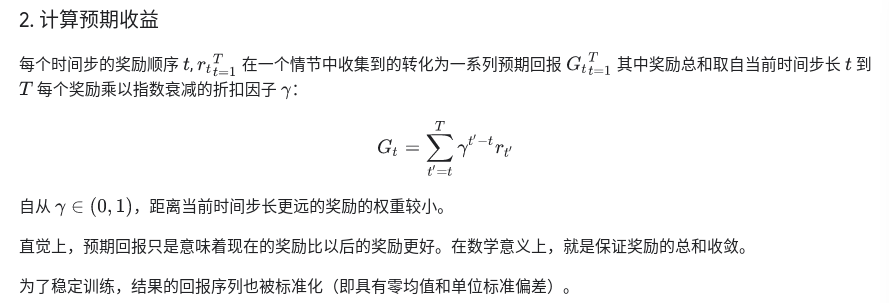

In [18]:
def get_expected_return(rewards:tf.Tensor,gamma:float,standardize:bool = True)->tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32,size=n)

   # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1],dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = discounted_sum * gamma + reward
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i,discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns  = ((returns - tf.math.reduce_mean(returns))/(tf.math.reduce_std(returns)+eps))
  
  return returns

3. The actor-critic loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as shown below:
> L = Lactor+Lcritic

Actor loss

The actor loss is based on policy gradients with the critic as a state dependent baseline and computed with single-sample (per-episode) estimates.
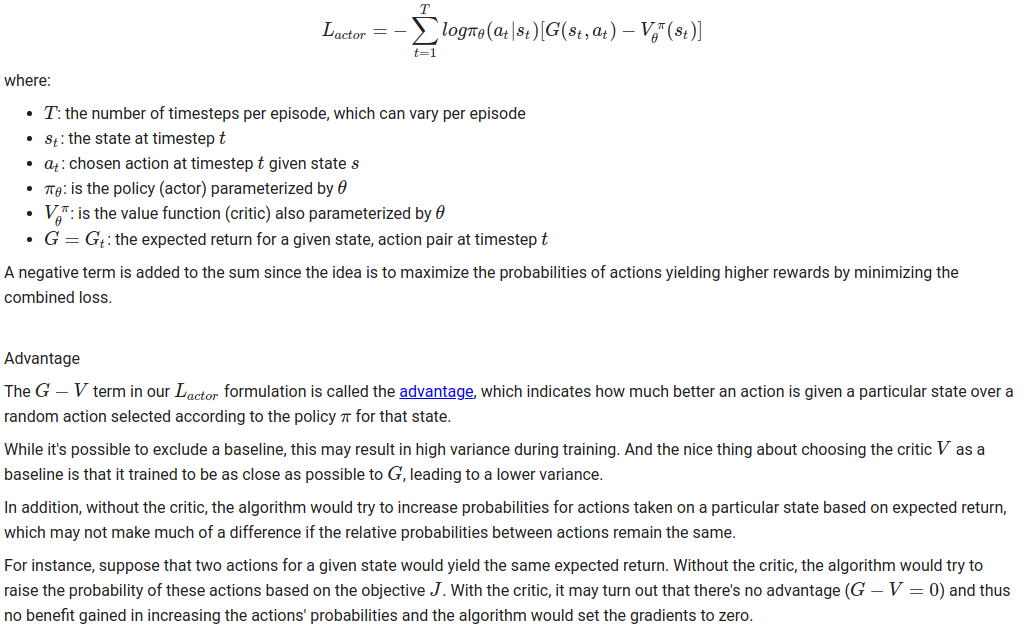


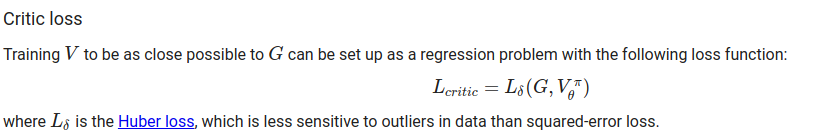

In [19]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)#实例是用来计算真实标签（ y_true ）和预测标签之间（ y_pred ）的loss损失。

def compute_loss(action_probs:tf.Tensor,values:tf.Tensor,returns:tf.Tensor)->tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values,returns)

  return actor_loss + critic_loss


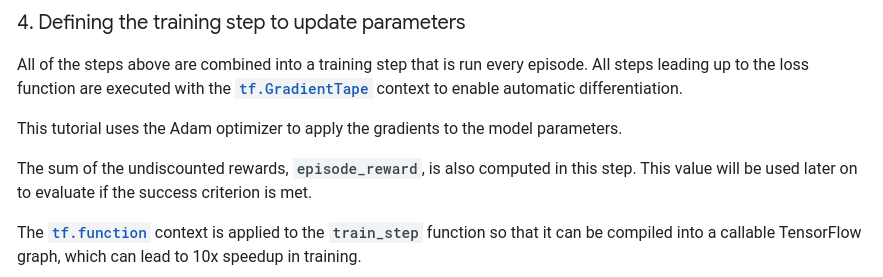

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(
    initial_state:tf.Tensor,
    model:tf.keras.Model,
    optimizer:tf.keras.optimizers.Optimizer,
    gamma:float,
    max_steps_per_episode:int)->tf.Tensor:
  """Runs a model training step"""

  # 上述所有步骤组合成一个训练步骤，每episode运行一次。
  # 损失函数的所有步骤都使用 tf.GradientTape 上下文执行以启用自动微分。
  with tf.GradientTape() as tape:
    # Run the model for one episode to collect training data
    action_probs,values,rewards = run_episode(initial_state, model,max_steps_per_episode)
    

    # Create expected returns
    returns = get_expected_return(rewards,gamma)

    # convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [tf.expand_dims(x,1) for x in [action_probs, values, returns]]

    # calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

    # compute the gradients to the model's parameters
  grads = tape.gradient(loss,model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads,model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward


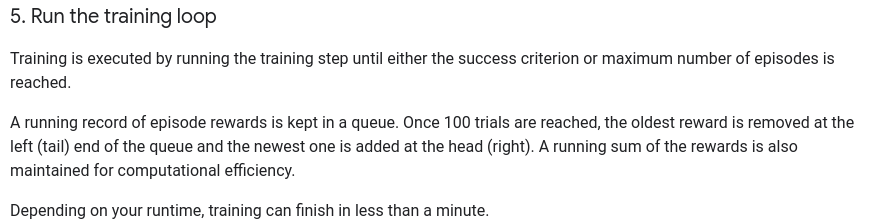

In [21]:
# %%time
# %%time 将会给出cell的代码运行一次所花费的时间。


min_episode_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials

reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# keep last episodes reward
# 创建容器 存储变量
episodes_reward:collections.deque = collections.deque(maxlen=min_episode_criterion)

# 进度条工具
with tqdm.trange(max_episodes) as t:
  # print(t)
  for i in t:
    initial_state = tf.constant(env.reset(),dtype=tf.float32)
    
    episode_reward = int(train_step(initial_state,model,optimizer,gamma,max_steps_per_episode))

    episodes_reward.append(episode_reward)
    # statistics统计
    running_reward = statistics.mean(episodes_reward)
    # 显示
    t.set_description(f'Episode{i}')
    t.set_postfix(episode_reward=episode_reward,running_reward=running_reward) 

    # Show average episode reward every 10 episodes
    if i%10==0:
      pass 
      # print(f'Episode {i}: average reward: {avg_reward}')
    
    if running_reward > reward_threshold and i >= min_episode_criterion:
      break
    
print(f'\nSolved at episode {i}:average reward:{running_reward:.2f}!')

Episode604:   6%|▌         | 604/10000 [00:35<09:19, 16.80it/s, episode_reward=200, running_reward=196]


Solved at episode 604:average reward:196.34!


Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for OpenAI Gym to render the environment's images correctly in Colab.

In [22]:
%%bash
# sudo apt-get upgrade
sudo apt-get install  xvfb
pip install xvfbwrapper
pip install pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [23]:

# Render an episode and save as a GIF file
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

display = Display(visible=0,size=(400,300))
display.start()

def render_episode(env:gym.Env, model:tf.keras.Model, max_steps:int):
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(),dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ =env.step(action)
    staet = tf.constant(state, dtype=tf.float32)

    # render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# save gif image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'

# loop = 0 :loop forever, duration=1: play each frame for 1ms
images[0].save(image_file,save_all=True, append_images=images[1:], loop=0, duration=1)

In [31]:
# !pip install  git+https://gitee.com/hejuncheng1/tensorflow-docs.git
!pip install webp==0.1.1
import tensorflow_docs.vis.embed as embed

embed.embed_file(image_file)

  Using cached webp-0.1.1.tar.gz (10 kB)
ERROR: Could not find a version that satisfies the requirement webp==0.1.1 (from versions: 0.1.0a4, 0.1.0a5, 0.1.0a6, 0.1.0a7, 0.1.0a9, 0.1.0a10, 0.1.0a11, 0.1.0a12, 0.1.0a13, 0.1.0a14, 0.1.0a15, 0.1.0a16, 0.1.0, 0.1.1)
ERROR: No matching distribution found for webp==0.1.1


ModuleNotFoundError: ignored